# Visualize epidemiological parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from mesa.batchrunner import BatchRunner
from os.path import join
from itertools import product

from scseirx.model_school import SEIRX_school # agent-based simulation
from scseirx import analysis_functions as af # custom analysis functions

In [2]:
school_characteristics = {
    # Volksschule: Schulen: 3033, Klassen: 18245, Schüler*innen: 339382
    'primary':            {'classes':8, 'students':19, 'floors':1},
    'primary_dc':         {'classes':8, 'students':19, 'floors':1},
    
    # Hauptschulen: 47, Klassen 104, Schüler*innen: 1993
    # Neue Mittelschule: Schulen 1131, Klassen: 10354, Schüler*innen: 205905
    # Sonderschulen: 292, Klassen: 1626, Schüler*innen: 14815
    # Gesamt: Schulen: 1470, Klassen: 12084, Schüler*innen: 222713
    'lower_secondary':    {'classes':8, 'students':18, 'floors':1},
    'lower_secondary_dc': {'classes':8, 'students':18, 'floors':1},
    
    # Oberstufenrealgymnasium: Schulen 114, Klassen 1183, Schüler*innen: 26211
    # BMHS: schulen 734, Klassen 8042, Schüler*innen 187592
    # Gesamt: Schulen: 848, Klassen 9225, Schüler*innen: 213803
    'upper_secondary':    {'classes':10, 'students':23, 'floors':1}, # rounded down from 10.8 classes
    
    # AHS Langform: Schulen 281, Klassen 7610, schüler*innen 179633
    'secondary':          {'classes':28, 'students':24, 'floors':1}, # rounded up from 27.1 classes
    'secondary_dc':       {'classes':28, 'students':24, 'floors':1} # rounded up from 27.1 classes
}

In [3]:
school_type = 'secondary'

In [4]:
school = {'type':school_type,
          'classes':school_characteristics[school_type]['classes'],
          'students':school_characteristics[school_type]['students'],
          'floors':school_characteristics[school_type]['floors']}

school_path = '../data/contact_networks/{}'.format(school_type)

In [8]:
school = {'type':school_type,
          'classes':8,
          'students':10,
          'floors':1}

school_path = '../../data/contact_networks/representative_schools/primary'

In [10]:
N_steps = 100
verbosity = 0
seed = 11

G = nx.readwrite.gpickle.read_gpickle(\
            join(school_path, 'primary_classes-8_students-19_network.bz2'))

testing = 'preventive'
index_case = 'teacher'
preventive_screening_test_type = 'same_day_antigen0.4'
diagnostic_test_type = 'two_day_PCR'
s_screen_interval = 3
t_screen_interval = 3
half_classes = False
student_mask = False
teacher_mask = False
mask_filter_efficiency  = {'exhale':0.5, 'inhale':0.7}
transmission_risk_ventilation_modifier = 1

agent_types = {
        'student':{
            'screening_interval': s_screen_interval,
            'index_probability': 0,
            'mask':student_mask,
            'voluntary_testing_rate':0.10},
    
        'teacher':{
            'screening_interval': t_screen_interval,
            'index_probability': 0,
            'mask':teacher_mask,
            'voluntary_testing_rate':0.10},
    
        'family_member':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False,
            'voluntary_testing_rate':1}
}

model = SEIRX_school(G, verbosity, 
              base_transmission_risk = 0.0737411844049918 * 10,
              testing = testing,
              diagnostic_test_type = diagnostic_test_type,
              preventive_screening_test_type = preventive_screening_test_type,
              infection_risk_contact_type_weights={
                    'very_far': 0.1, 'far': 0.75,\
                    'intermediate': 0.85, 'close': 1},
              index_case = index_case,
              subclinical_modifier = 0.6,
              exposure_duration = [5, 1.9],
              time_until_symptoms = [6.4, 0.8],
              infection_duration = [10.91, 3.95],
              follow_up_testing_interval = None,
              agent_types = agent_types, 
              age_transmission_risk_discount = {'slope':-0.05, 'intercept':1},
              age_symptom_modification = {'slope':-0.02545, 'intercept':0.854545},
              mask_filter_efficiency = mask_filter_efficiency,
              transmission_risk_ventilation_modifier = transmission_risk_ventilation_modifier,
              seed=seed)

In [11]:
def weibull_two_param(shape, scale):
    '''
    A two-parameter Weibull distribution, based on numpy ramdon's single 
    parameter distribution. We use this distribution in the simulation to draw
    random epidemiological parameters for agents from the given distribution
    See https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html
    '''
    return scale * np.random.weibull(shape)

In [12]:
exposure_duration = []
time_until_symptoms = []
infection_duration = []
for i in range(10000):
    tmp_epi_params = {}
    # for each of the three epidemiological parameters, check if
    # the parameter is an integer (if yes, pass it directly to the
    # agent constructor), or if it is specified by the shape and 
    # scale parameters of a Weibull distribution. In the latter 
    # case, draw a new number for every agent from the distribution
    # NOTE: parameters drawn from the distribution are rounded to
    # the nearest integer
    while True:
        for param_name, param in model.epi_params.items():
            if isinstance(param, int):
                tmp_epi_params[param_name] = param

            else:
                tmp_epi_params[param_name] = \
                    round(weibull_two_param(param[0], param[1]))

        if tmp_epi_params['exposure_duration'] > 0 and \
           tmp_epi_params['time_until_symptoms'] >= \
           tmp_epi_params['exposure_duration'] and\
           tmp_epi_params['infection_duration'] > \
           tmp_epi_params['exposure_duration']:
           break
        else:
            model.param_rerolls += 1
            if verbosity > 1:
                print('pathological epi-param case found!')
                print(tmp_epi_params)
                
    exposure_duration.append(tmp_epi_params['exposure_duration'])
    time_until_symptoms.append(tmp_epi_params['time_until_symptoms'])
    infection_duration.append(tmp_epi_params['infection_duration'])

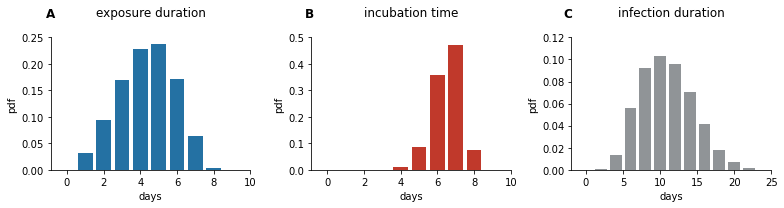

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
fig.subplots_adjust(wspace=0.3)
max_bins = [11, 11, 26]
steps = [1, 1, 2]
colors = ['#2471A3', '#C0392B', '#909497']
xticks = [range(0, 11, 2), range(0, 11, 2), range(0, 26, 5)]
labels = ['exposure duration\n', 'incubation time\n', 'infection duration\n']
ymaxes = [0.25, 0.5, 0.12]

for ax, max_bin, step, color, xtick, label, ymax, param in zip(axes, max_bins, steps, colors,\
    xticks, labels, ymaxes, [exposure_duration, time_until_symptoms, infection_duration]):
    ax.hist(param, bins=range(0, max_bin, step), rwidth=0.8, color=color,
            density=True, align='left')
    ax.set_xticks(xtick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(label)
    ax.set_ylabel('pdf')
    ax.set_xlabel('days')
    ax.set_ylim(0, ymax)

fig.tight_layout()
fig.text(0.062, 0.9, 'A', fontsize=12, fontweight='bold')
fig.text(0.39, 0.9, 'B', fontsize=12, fontweight='bold')
fig.text(0.7162, 0.9, 'C', fontsize=12, fontweight='bold')
plt.savefig('../../plots/epi_param_distributions.pdf')
plt.savefig('../../plots/epi_param_distributions.svg')
plt.savefig('../../plots/epi_param_distributions.png', dpi=300)